## Train deep equilibrium (DEQ) model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
from matplotlib import cm
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

# device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#Dynamics functions
f = lambda x: 0.7
sigma = lambda x: 1.0

class TanhFixedPointLayer(nn.Module):
    def __init__(self, out_features, tol=1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter

    def forward(self, x):
        # initialize output z to be zero
        z = torch.zeros_like(x)
        self.iterations = 0

        # iterate until convergence
        while self.iterations < self.max_iter:
            z_next = torch.tanh(self.linear(z) + x)
            self.err = torch.norm(z - z_next)
            z = z_next
            self.iterations += 1
            if self.err < self.tol:
                break

        return z


class TanhNewtonImplicitLayer(nn.Module):
    def __init__(self, out_features, tol=1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter

    def forward(self, x):
        # Run Newton's method outside of the autograd framework
        with torch.no_grad():
            z = torch.tanh(x)
            self.iterations = 0
            while self.iterations < self.max_iter:
                z_linear = self.linear(z) + x
                g = z - torch.tanh(z_linear)
                self.err = torch.norm(g)
                if self.err < self.tol:
                    break

                # newton step
                J = torch.eye(z.shape[1])[None, :, :].to(device) - (1 / torch.cosh(z_linear) ** 2)[:, :,
                                                        None] * self.linear.weight[None, :, :]
                z = z - torch.linalg.solve(J, g[:, :, None])[:, :, 0]
                self.iterations += 1

        # reengage autograd and add the gradient hook
        z = torch.tanh(self.linear(z) + x)
        z.register_hook(lambda grad: torch.linalg.solve(J.transpose(1, 2), grad[:, :, None])[:, :, 0])
        return z

def physics_loss(model, x, T):
    # Define your physics-informed loss function
    x.requires_grad_(True)
    T.requires_grad_(True)
    u = model(x, T)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_T = torch.autograd.grad(u, T, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    loss_pde = torch.mean((u_T - 0.5*((sigma(x))**2)*u_xx - f(x)*u_x)**2) # PDE loss
    return  0.5 * 10000 * loss_pde # multiplied by 10000 so that physics and boundary losses are comparable

def boundary_loss(model, x, T, F):
    # x.requires_grad_(True)
    # T.requires_grad_(True)
    u = model(x, T)
    loss_boundary = 0.5 * torch.mean((u - F) ** 2)  # Boundary loss may need some more weight since there is less boundary data
    return loss_boundary

# Optimizer and model instantiation
torch.manual_seed(0)

class DEQ_model(nn.Module):
    def __init__(self):
        super(DEQ_model, self).__init__()
        # Define your neural network architecture
        self.fc1 = nn.Linear(2, 50)  # Input: (x, t)
        self.implicit_layer = TanhNewtonImplicitLayer(50, max_iter=40) #50 x 50 weight matrix weight tied
        self.fc2 = nn.Linear(50, 1)   #2650 params total

    def forward(self, x, T):
        # Concatenate space and time
        input_data = torch.cat((x.unsqueeze(1), T.unsqueeze(1)), dim=1)
        # Forward pass through the network
        out = self.fc1(input_data)
        out = self.implicit_layer(out)
        out = self.fc2(out)
        return out
    
# Data loading and pre-processing

loaded_boundary_data = np.load('1_d_boundary_data.npy', allow_pickle= True)
x_T_tr_b = loaded_boundary_data[:,0]
x_T_tr_b_array = [list(i) for i in zip(*x_T_tr_b)]
x_tr_b = np.array([]) #empty array
T_tr_b = np.array([]) #empty array
F_tr_b = loaded_boundary_data[:,1]
F_tr_b = np.array(F_tr_b, dtype= float)
for state in x_T_tr_b_array[0]:
    x_tr_b = np.append(x_tr_b, state[0])
for time in x_T_tr_b_array[1]:
    T_tr_b = np.append(T_tr_b, time)

loaded_physics_data = np.load('1_d_interior_data.npy', allow_pickle=True)
x_T_tr_p = loaded_physics_data[:,0]
x_T_tr_p_array = [list(i) for i in zip(*x_T_tr_p)]
x_tr_p = np.array([]) #empty array
T_tr_p = np.array([]) #empty array
F_tr_p = loaded_physics_data[:,1]
F_tr_p = np.array(F_tr_p, dtype= float)
for state in x_T_tr_p_array[0]:
    x_tr_p = np.append(x_tr_p, state[0])
for time in x_T_tr_p_array[1]:
    T_tr_p = np.append(T_tr_p, time)

N_b = np.shape(T_tr_b)[0] # boundary data size
N_p = np.shape(T_tr_p)[0] # physics data size
# an 80-20% split of training and test data on both boundary and physics data
N_b_tr = int(N_b * 0.8)
N_p_tr = int(N_p * 0.8)
N_b_te = N_b - N_b_tr
N_p_te = N_p - N_p_tr

# # Now we shuffle all data
# boundary_indices = np.random.permutation(N_b)
# physics_indices = np.random.permutation(N_p)
# x_tr_b = x_tr_b[boundary_indices]
# T_tr_b = T_tr_b[boundary_indices]
# F_tr_b = F_tr_b[boundary_indices]
# x_tr_p = x_tr_p[physics_indices]
# T_tr_p = T_tr_p[physics_indices]
# F_tr_p = F_tr_p[physics_indices]

x_te_b = x_tr_b[N_b_tr:]
T_te_b = T_tr_b[N_b_tr:]
F_te_b = F_tr_b[N_b_tr:]
x_tr_b = x_tr_b[0:N_b_tr]
T_tr_b = T_tr_b[0:N_b_tr]
F_tr_b = F_tr_b[0:N_b_tr]

x_te_p = x_tr_p[N_p_tr:]
T_te_p = T_tr_p[N_p_tr:]
F_te_p = F_tr_p[N_p_tr:]
x_tr_p = x_tr_p[0:N_p_tr]
T_tr_p = T_tr_p[0:N_p_tr]
F_tr_p = F_tr_p[0:N_p_tr]


model = DEQ_model().to(device)
optimizer_p = optim.Adam(model.parameters(), lr=0.001)
optimizer_b = optim.Adam(model.parameters(), lr= 0.02)

# define lists for plotting
train_boundary_losses = []
train_physics_losses = []
val_boundary_losses = []
val_physics_losses = []

# Training loop
num_epochs = 25
physics_batch_size = 100
boundary_batch_size = 100
for epoch in range(num_epochs):

    l_boundary_epoch_average = 0
    l_physics_epoch_average = 0
    for i in range(0,N_b_tr,boundary_batch_size): # runs same as "for i in range(0, N_p_tr, physics_batch_size):"
        batch_x_tr_b = torch.tensor(x_tr_b[i:i+boundary_batch_size],dtype=torch.float).to(device)
        batch_T_tr_b = torch.tensor(T_tr_b[i:i+boundary_batch_size],dtype=torch.float).to(device)
        batch_F_tr_b = torch.tensor(F_tr_b[i:i+boundary_batch_size], dtype=torch.float).to(device)
        batch_x_tr_p = torch.tensor(x_tr_p[i:i + physics_batch_size], dtype=torch.float).to(device)
        batch_T_tr_p = torch.tensor(T_tr_p[i:i + physics_batch_size], dtype=torch.float).to(device)
        # Compute boundary loss
        l_b = boundary_loss(model,batch_x_tr_b,batch_T_tr_b,batch_F_tr_b)
        # Optimization step
        optimizer_b.zero_grad()
        l_b.backward()
        if sum(torch.sum(torch.isnan(p.grad)) if p.grad is not None else 0 for p in model.parameters()) == 0:
            optimizer_b.step()
        # Compute physics loss
        l_p = physics_loss(model, batch_x_tr_p, batch_T_tr_p)
        # Optimization step
        optimizer_p.zero_grad()
        l_p.backward()
        if sum(torch.sum(torch.isnan(p.grad)) if p.grad is not None else 0 for p in model.parameters()) == 0:
            optimizer_p.step()
        # Accumulate average loss
        l_boundary_epoch_average += l_b.item()
        l_physics_epoch_average += l_p.item()
    l_boundary_epoch_average = l_boundary_epoch_average *(1/(N_b_tr/boundary_batch_size))
    l_physics_epoch_average = l_physics_epoch_average * (1 / (N_p_tr / physics_batch_size))
    
    
    # test prediction
    model.eval()
    boundary_val_loss = boundary_loss(model, torch.tensor(x_te_b, dtype=torch.float, device=device), torch.tensor(T_te_b, dtype=torch.float, device=device), torch.tensor(F_te_b, dtype=torch.float, device=device))
    physics_val_loss = physics_loss(model, torch.tensor(x_te_p, dtype=torch.float, device=device), torch.tensor(T_te_p, dtype=torch.float, device=device))
    
    # Save the average losses for plotting
    train_boundary_losses.append(l_boundary_epoch_average)
    train_physics_losses.append(l_physics_epoch_average)
    val_boundary_losses.append(boundary_val_loss.item())
    val_physics_losses.append(physics_val_loss.item())
    
    # Print loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Boundary Loss: {l_boundary_epoch_average:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Physics Loss: {l_physics_epoch_average:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Eval Boundary Loss: {boundary_val_loss.item():.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Eval Physics Loss: {physics_val_loss.item():.4f}")


# fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # Two subplots in one column
# predict 


   # Now we evaluate performance on test data
"""
test_physics_loss = physics_loss(model, torch.tensor(x_te_p, dtype=torch.float), torch.tensor(T_te_p, dtype=torch.float))
print(test_physics_loss)


test_boundary_loss = boundary_loss(model, torch.tensor(x_te_b, dtype=torch.float), torch.tensor(T_te_b, dtype= torch.float),
                                                        torch.tensor(F_te_b, dtype=torch.float))
print(test_boundary_loss)
"""
# figure_of_merit = torch.sqrt(2.0 * boundary_loss(model, torch.tensor(x_te_p, dtype= torch.float).to(device), torch.tensor(T_te_p, dtype= torch.float).to(device),
#                                 torch.tensor(F_te_p, dtype = torch.float).to(device)))

# print(figure_of_merit)

# # Save the model
model_path = "checkpoints/deq.pth"
torch.save(model.state_dict(), model_path)


Epoch [1/25], Train Boundary Loss: 0.0900
Epoch [1/25], Train Physics Loss: 3.3940
Epoch [1/25], Eval Boundary Loss: 0.0787
Epoch [1/25], Eval Physics Loss: 2030.5355
Epoch [2/25], Train Boundary Loss: 0.0798
Epoch [2/25], Train Physics Loss: 152.7032
Epoch [2/25], Eval Boundary Loss: 0.0806
Epoch [2/25], Eval Physics Loss: 2.3621
Epoch [3/25], Train Boundary Loss: 0.0798
Epoch [3/25], Train Physics Loss: 0.8398
Epoch [3/25], Eval Boundary Loss: 0.0872
Epoch [3/25], Eval Physics Loss: 2.7191
Epoch [4/25], Train Boundary Loss: 0.0795
Epoch [4/25], Train Physics Loss: 0.6193
Epoch [4/25], Eval Boundary Loss: 0.0787
Epoch [4/25], Eval Physics Loss: 0.7838
Epoch [5/25], Train Boundary Loss: 0.0791
Epoch [5/25], Train Physics Loss: 0.4893
Epoch [5/25], Eval Boundary Loss: 0.0794
Epoch [5/25], Eval Physics Loss: 0.6828
Epoch [6/25], Train Boundary Loss: 0.0792
Epoch [6/25], Train Physics Loss: 0.4685
Epoch [6/25], Eval Boundary Loss: 0.0797
Epoch [6/25], Eval Physics Loss: 0.5640
Epoch [7/25

## Train the fully connect (FC) model

In [2]:
# baseline model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Define your neural network architecture
        self.fc1 = nn.Linear(2, 50)  # Input: (x, t)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 1)  # Output: temperature

    def forward(self, x, T):
        # Concatenate space and time
        input_data = torch.cat((x.unsqueeze(1), T.unsqueeze(1)), dim=1)
        input_data = input_data.to(device)
        # Forward pass through the network
        out = torch.tanh(self.fc1(input_data))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out
    
# Optimizer and model instantiation

model_base = PINN().to(device)
optimizer_p_base = optim.Adam(model_base.parameters(), lr=0.001)
optimizer_b_base = optim.Adam(model_base.parameters(), lr= 0.001)

# define lists for plotting
train_boundary_losses_base = []
train_physics_losses_base = []
val_boundary_losses_base = []
val_physics_losses_base = []
for epoch in range(num_epochs):

    l_boundary_epoch_average = 0
    l_physics_epoch_average = 0
    for i in range(0,N_b_tr,boundary_batch_size): # runs same as "for i in range(0, N_p_tr, physics_batch_size):"
        batch_x_tr_b = torch.tensor(x_tr_b[i:i+boundary_batch_size],dtype=torch.float)
        batch_T_tr_b = torch.tensor(T_tr_b[i:i+boundary_batch_size],dtype=torch.float)
        batch_F_tr_b = torch.tensor(F_tr_b[i:i+boundary_batch_size], dtype=torch.float)
        batch_x_tr_p = torch.tensor(x_tr_p[i:i + physics_batch_size], dtype=torch.float)
        batch_T_tr_p = torch.tensor(T_tr_p[i:i + physics_batch_size], dtype=torch.float)
        # Compute boundary loss
        l_b = boundary_loss(model_base,batch_x_tr_b,batch_T_tr_b,batch_F_tr_b)
        # Optimization step
        optimizer_b_base.zero_grad()
        l_b.backward()
        optimizer_b_base.step()
        # Compute physics loss
        l_p = physics_loss(model_base, batch_x_tr_p, batch_T_tr_p)
        # Optimization step
        optimizer_p_base.zero_grad()
        l_p.backward()
        optimizer_p.step()
        # Accumulate average loss
        l_boundary_epoch_average += l_b.item()
        l_physics_epoch_average += l_p.item()
    l_boundary_epoch_average = l_boundary_epoch_average *(1/(N_b_tr/boundary_batch_size))
    l_physics_epoch_average = l_physics_epoch_average * (1 / (N_p_tr / physics_batch_size))
    
    # test prediction
    model.eval()
    boundary_val_loss = boundary_loss(model_base, torch.tensor(x_te_b, dtype=torch.float, device=device), torch.tensor(T_te_b, dtype=torch.float, device=device), torch.tensor(F_te_b, dtype=torch.float, device=device))
    physics_val_loss = physics_loss(model_base, torch.tensor(x_te_p, dtype=torch.float, device=device), torch.tensor(T_te_p, dtype=torch.float, device=device))
    # Save the average losses for plotting
    train_boundary_losses_base.append(l_boundary_epoch_average)
    train_physics_losses_base.append(l_physics_epoch_average)
    val_boundary_losses_base.append(boundary_val_loss.item())
    val_physics_losses_base.append(physics_val_loss.item())
    
    # Print loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Boundary Loss: {l_boundary_epoch_average:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Physics Loss: {l_physics_epoch_average:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Eval Boundary Loss: {boundary_val_loss.item():.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Eval Physics Loss: {physics_val_loss.item():.4f}")

# # Save the model
model_path = "checkpoints/pipe.pth"
torch.save(model_base.state_dict(), model_path)

Epoch [1/25], Boundary Loss: 0.0806
Epoch [1/25], Physics Loss: 0.6966
Epoch [1/25], Eval Boundary Loss: 0.0779
Epoch [1/25], Eval Physics Loss: 0.3276
Epoch [2/25], Boundary Loss: 0.0785
Epoch [2/25], Physics Loss: 0.1346
Epoch [2/25], Eval Boundary Loss: 0.0780
Epoch [2/25], Eval Physics Loss: 0.2838
Epoch [3/25], Boundary Loss: 0.0785
Epoch [3/25], Physics Loss: 0.1051
Epoch [3/25], Eval Boundary Loss: 0.0780
Epoch [3/25], Eval Physics Loss: 0.2160
Epoch [4/25], Boundary Loss: 0.0785
Epoch [4/25], Physics Loss: 0.0805
Epoch [4/25], Eval Boundary Loss: 0.0780
Epoch [4/25], Eval Physics Loss: 0.1584
Epoch [5/25], Boundary Loss: 0.0785
Epoch [5/25], Physics Loss: 0.0615
Epoch [5/25], Eval Boundary Loss: 0.0779
Epoch [5/25], Eval Physics Loss: 0.1156
Epoch [6/25], Boundary Loss: 0.0785
Epoch [6/25], Physics Loss: 0.0482
Epoch [6/25], Eval Boundary Loss: 0.0779
Epoch [6/25], Eval Physics Loss: 0.0879
Epoch [7/25], Boundary Loss: 0.0785
Epoch [7/25], Physics Loss: 0.0397
Epoch [7/25], Eva

## Visualize the results

/tmp/ipykernel_9821/238458346.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4)


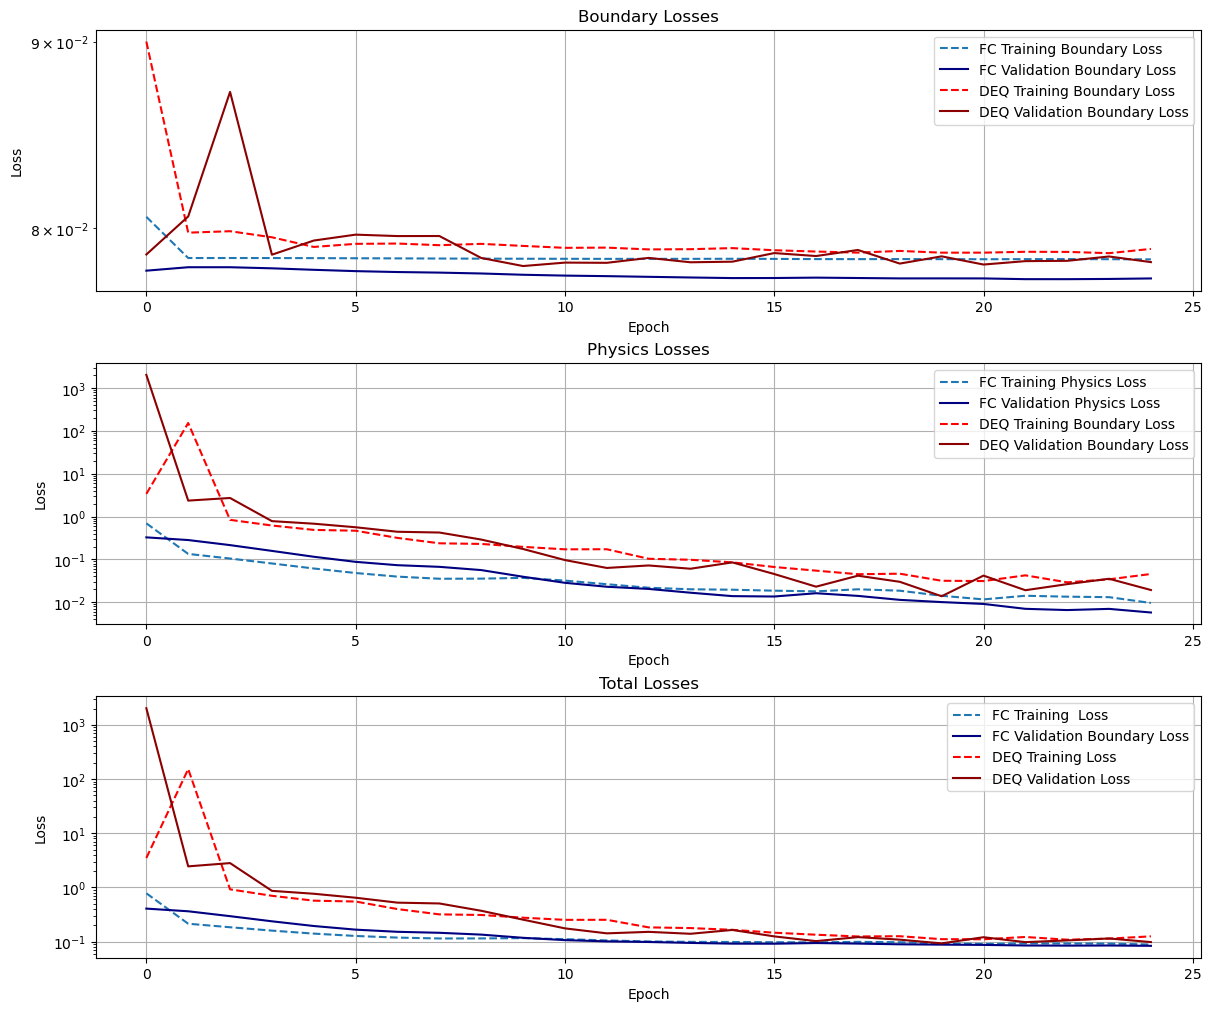

In [3]:
# Prepare the plot
fig, axs = plt.subplots(3, 1, figsize=(12, 10),  constrained_layout=True)  # Two subplots in one column

# Plot for boundary losses
axs[0].plot(train_boundary_losses_base, label='FC Training Boundary Loss', linestyle='--', color='tab:blue')
axs[0].plot(val_boundary_losses_base, label='FC Validation Boundary Loss', linestyle='-', color='navy')
axs[0].plot(train_boundary_losses, label='DEQ Training Boundary Loss', linestyle='--', color='red')
axs[0].plot(val_boundary_losses, label='DEQ Validation Boundary Loss', linestyle='-', color='darkred')
axs[0].set_title('Boundary Losses')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_yscale('log')
# axs[0].set_ylim(1e-5, 1e0)  # Set fixed log scale range
axs[0].legend()
axs[0].grid(True)

# Plot for physics losses
axs[1].plot(train_physics_losses_base, label='FC Training Physics Loss', linestyle='--', color='tab:blue')
axs[1].plot(val_physics_losses_base, label='FC Validation Physics Loss', linestyle='-', color='navy')
axs[1].plot(train_physics_losses, label='DEQ Training Boundary Loss', linestyle='--', color='red')
axs[1].plot(val_physics_losses, label='DEQ Validation Boundary Loss', linestyle='-', color='darkred')
axs[1].set_title('Physics Losses')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].grid(True)

# Plot for boundary losses
axs[2].plot(np.array(train_boundary_losses_base) + np.array(train_physics_losses_base), label='FC Training  Loss', linestyle='--', color='tab:blue')
axs[2].plot(np.array(val_boundary_losses_base) + np.array(val_physics_losses_base), label='FC Validation Boundary Loss', linestyle='-', color='navy')
axs[2].plot(np.array(train_boundary_losses) + np.array(train_physics_losses), label='DEQ Training Loss', linestyle='--', color='red')
axs[2].plot(np.array(val_boundary_losses) + np.array(val_physics_losses), label='DEQ Validation Loss', linestyle='-', color='darkred')
axs[2].set_title('Total Losses')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].set_yscale('log')
# axs[0].set_ylim(1e-5, 1e0)  # Set fixed log scale range
axs[2].legend()
axs[2].grid(True)

plt.subplots_adjust(hspace=0.4)

# Save the plot
plot_path = "plots/loss_all.png"
plt.savefig(plot_path)
plt.show()

## Check the model parameters

In [4]:
# check parameter
deq_params = sum(p.numel() for p in model.parameters())
fc_params = sum(p.numel() for p in model_base.parameters())
print(f"DEQ model has {deq_params} parameters, FC model has {fc_params} parameters")

DEQ model has 2701 parameters, FC model has 7851 parameters


# Visualize the recovery probability in 3D

In [5]:
X= np.concatenate((T_te_b, T_te_p))
Y = np.concatenate((x_te_b, x_te_p))
F_test = np.concatenate((F_te_b, F_te_p))
F_FC = model_base(torch.tensor(Y, dtype=torch.float, device=device), torch.tensor(X, dtype=torch.float, device=device)).detach().cpu().numpy().reshape(-1)
F_DEQ = model(torch.tensor(Y, dtype=torch.float, device=device), torch.tensor(X, dtype=torch.float, device=device)).detach().cpu().numpy().reshape(-1)

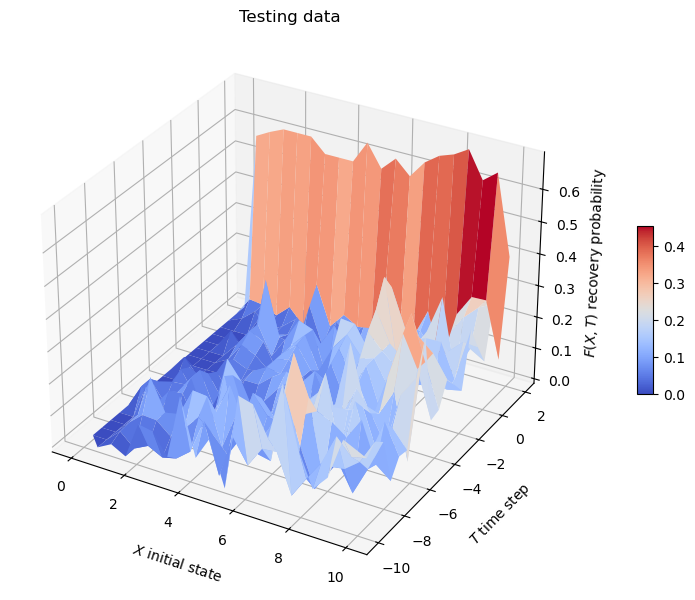

In [6]:
# Create a regular grid to interpolate the data.
xi = np.linspace(min(X),max(X),20) # time 
yi = np.linspace(min(Y),max(Y)-0.1,20) # state
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((X, Y), F_test, (xi, yi), method='linear')

# Create the plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap=plt.cm.coolwarm)

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('$X$ initial state', labelpad=10)
ax.set_ylabel('$T$ time step', labelpad=10)
ax.set_zlabel('$F(X,T)$ recovery probability')
ax.set_title("Testing data")

fig.colorbar(surf, shrink=0.3, aspect=10)

# Get the current position of the axes
pos = ax.get_position()

# Adjust the subplot margins
plt.subplots_adjust(left=0.1, right=2, top=0.9, bottom=0.1)
plt.savefig("plots/groundtruth.png")
plt.show()

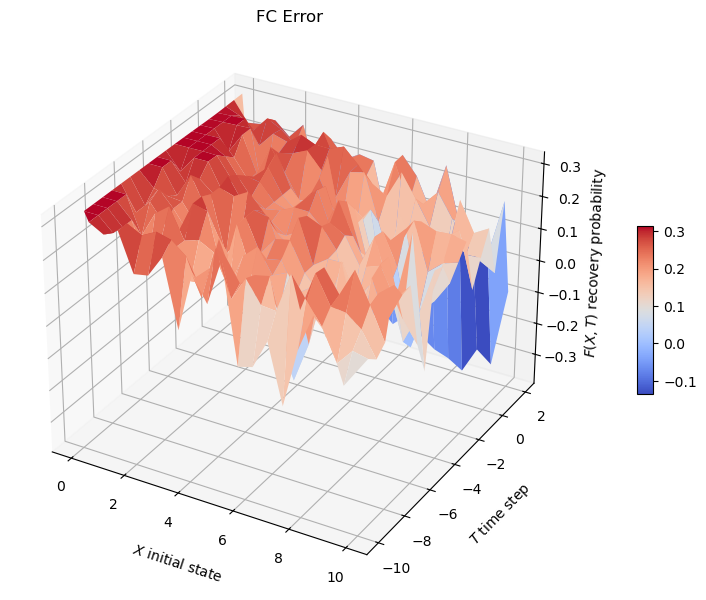

In [7]:
# Create a regular grid to interpolate the data.
xi = np.linspace(min(X),max(X),20) # time 
yi = np.linspace(min(Y),max(Y)-0.1,20) # state
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((X, Y), F_FC - F_test, (xi, yi), method='linear')

# Create the plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap=plt.cm.coolwarm)

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('$X$ initial state', labelpad=10)
ax.set_ylabel('$T$ time step', labelpad=10)
ax.set_zlabel('$F(X,T)$ recovery probability')
ax.set_title("FC Error")

fig.colorbar(surf, shrink=0.3, aspect=10)

# Get the current position of the axes
pos = ax.get_position()

# Adjust the subplot margins
plt.subplots_adjust(left=0.1, right=2, top=0.9, bottom=0.1)
plt.savefig("plots/FC_error.png")
plt.show()

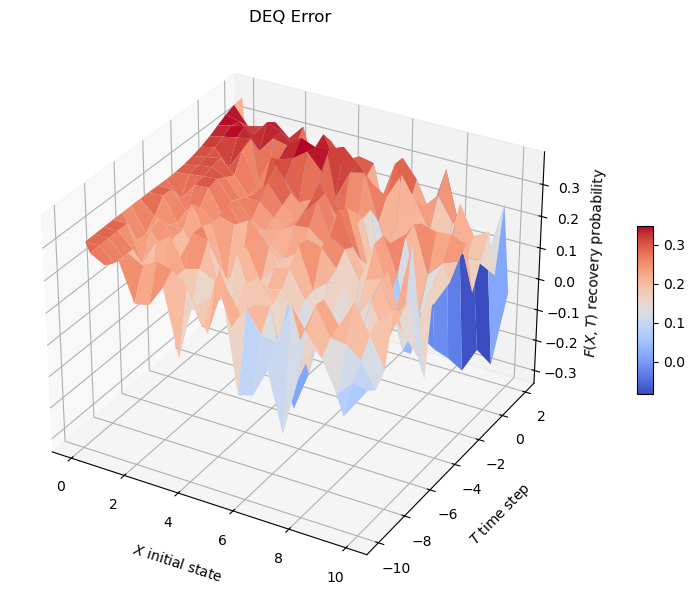

In [8]:
# Create a regular grid to interpolate the data.
xi = np.linspace(min(X),max(X),20) # time 
yi = np.linspace(min(Y),max(Y)-0.1,20) # state
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values on the grid
zi = griddata((X, Y), F_DEQ - F_test, (xi, yi), method='linear')

# Create the plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap=plt.cm.coolwarm)

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('$X$ initial state', labelpad=10)
ax.set_ylabel('$T$ time step', labelpad=10)
ax.set_zlabel('$F(X,T)$ recovery probability')
ax.set_title("DEQ Error")

fig.colorbar(surf, shrink=0.3, aspect=10)

# Get the current position of the axes
pos = ax.get_position()

# Adjust the subplot margins
plt.subplots_adjust(left=0.1, right=2, top=0.9, bottom=0.1)
plt.savefig("plots/DEQ_error.png")
plt.show()